# Retrievals: Exploring the built-in models

Written by [Evert Nasedkin](mailto:nasedkinevert@gmail.com?subject=[petitRADTRANS]%20Retrievals).

Please cite pRT's retrieval package [(Nasedkin et al. 2024)](https://ui.adsabs.harvard.edu/abs/2024JOSS....9.5875N/abstract) in addition to pRT [(Mollière et al. 2019)](https://ui.adsabs.harvard.edu/abs/2019A%26A...627A..67M/abstract) if you make use of the retrieval package for your work.

In this tutorial we'll demonstrate how to use the built in set of retrieval models.

For simplicity, we'll use the model directly. In the context of a retrieval, you'll need to add the corresponding parameters to `RetrievalConfig` for the chosen forward model and set up their priors or fixed values. Then you need to associate the model function with the data that you're performing the retrieval on.

We recommend using the built in models for most standard use cases, or to use `SpectralModel`s (see the [SpectralModel retrieval notebook](./retrieval_spectral_model.ipynb)).

In [1]:
# Let's start by importing everything we need
import os

import matplotlib.pyplot as plt
import numpy as np

import petitRADTRANS as prt
from petitRADTRANS import physical_constants as cst
from petitRADTRANS.retrieval.parameter import Parameter
from petitRADTRANS.plotlib.style import set_petitradtrans_plot_style

set_petitradtrans_plot_style()

Using pRT Plotting style!


## Emission spectrum models

Let's start with the emission models. For every model we need to supply two of the `mass`, `R_pl` or `log_g` in order to compute the surface gravity of the object.
All of the models can combine various cloud implementations, see the [cloud tutorial](./including_clouds.ipynb) for more information.
Most of the models can use either (dis)equilibrium or free chemistry, or some combination of the two.
For the specific details of the required parameters, see the [API documentation](../../autoapi/petitRADTRANS/retrieval/models/index.html).

- `emission_model_diseq`: This model is based on [Mollière et al. (2020)](https://ui.adsabs.harvard.edu/abs/2020A%26A...640A.131M/abstract). It uses an adiabatic profile deep in the atmosphere, an Eddington profile in the mid regions and a spline profile in the upper atmosphere. It requires the use of (dis)equilibrium chemistry, as the temperature profile depends on both the atmospheric metallicity `Fe/H` (actually meaning [Fe/H]) and the `C/O` ratio.
- `emission_model_diseq_patchy_clouds`: As above, this model is based on Mollière et al. (2020). However, here we'll need to supply parameters for an additional temperature profile to describe the clear atmosphere region, as well as a `patchiness` parameter that sets the fraction of the planet covered in clouds.
- `emission_model_diseq_simple_patchy_clouds`: Similarly, this is a patchy cloud model, but the entire planet uses the same temperature profile.
- `guillot_emission`: This model is based on the temperature profile of [Guillot (2010)](https://ui.adsabs.harvard.edu/abs/2010A%26A...520A..27G/abstract). It can be used with either free or disequilibrium chemistry.
- `guillot_patchy_emission`: Also using the Guillot profile, but allowing for patchy clouds.
- `interpolated_profile_emission`:  This model uses a spline profile throughout the atmosphere. We can choose the number of nodes between which to interpolate, and whether to use a linear or cubic spline. 
- `gradient_profile_emission`: This model is based of the temperature gradient profile described in [Zhang et al. (2023)](https://ui.adsabs.harvard.edu/abs/2023AJ....166..198Z/abstract). This model uses tight priors on the temperature gradient at fixed pressure levels to determine the overall temperature profile.


In [2]:
from petitRADTRANS.retrieval.models import (
    emission_model_diseq,
    emission_model_diseq_patchy_clouds,
    emission_model_diseq_simple_patchy_clouds,
    guillot_emission,
    guillot_patchy_emission,
    interpolated_profile_emission,
    gradient_profile_emission
)
                                           

We'll only set up one model here, but the idea is the same for the rest of the models.
We need to define all of the parameters necessary, setup a `Radtrans` object, and then we can calculate the spectrum.
Here we'll set up an emission spectrum for a planet similar to those in the HR 8799 system.
*Again, remember that this is different from the retrieval workflow*, where the `Retrieval` object makes the `Radtrans` object; here we just want to calculate a model in isolation.

In [3]:
parameters = {
    # Planet parameters
    'D_pl': Parameter('D_pl', False, value=10.0 * cst.pc),
    'mass': Parameter('mass', False, value=5 * cst.m_jup),
    'planet_radius': Parameter('planet_radius', False, value=1 * cst.r_jup_mean),
    # Temperature parameters
    'T_int': Parameter('T_int', False, value=1500.0), 
    'T1': Parameter('T1', False, value=0.5),
    'T2': Parameter('T2', False, value=0.4), 
    'T3': Parameter('T3', False, value=0.8),
    'log_delta': Parameter('log_delta', False, value=0.65), 
    'alpha': Parameter('alpha', False, value=1.70),
    # Chemical parameters
    'Fe/H': Parameter('[Fe/H]', False, value=1.0), 
    'C/O': Parameter('C/O', False, value=0.7),
    'log_pquench': Parameter('log_pquench', False, value=2.5),
    # Cloud parameters
    'sigma_lnorm': Parameter('sigma_lnorm', False, value=1.25),
    'fsed_MgSiO3(s)': Parameter('fsed_MgSiO3(s)', False, value=0.05),
    'fsed_Fe(s)': Parameter('fsed_Fe(s)', False, value=7.5), 
    'log_kzz': Parameter('log_kzz', False, value=5),
    'eq_scaling_Fe(s)': Parameter('eq_scaling_Fe(s)', False, value=-0.3),
    'eq_scaling_MgSiO3(s)': Parameter('eq_scaling_MgSiO3(s)', False, value=-1.00)
}

In [4]:
line_species = [
    'H2O__POKAZATEL.R300', 
    'CO-NatAbund.R300', 
    'CH4.R300', 
    'CO2.R300', 
    'HCN.R300', 
    'FeH.R300', 
    'H2S.R300', 
    'NH3.R300', 
    'PH3.R300', 
    'Na.R300', 
    'K.R300', 
    'TiO.R300', 
    'VO.R300',
    'SiO.R300'
]

rayleigh_species = ['H2', 'He']
continuum_opacities = ['H2--H2', 'H2--He']
cloud_species = ['MgSiO3(s)_crystalline__DHS', 'Fe(s)_crystalline__DHS']
pressures = np.logspace(-6, 2, 100)

atmosphere = prt.radtrans.Radtrans(
    pressures=pressures,
    line_species=line_species,
    rayleigh_species=rayleigh_species,
    gas_continuum_contributors=continuum_opacities,
    cloud_species=cloud_species,
    wavelength_boundaries=[1, 5]
)


Loading Radtrans opacities...
 Done.ng line opacities of species 'H2O__POKAZATEL.R300' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/H2O/1H2-16O/1H2-16O__POKAZATEL.R300_0.3-50mu.ktable.petitRADTRANS.h5'...
 Done.ng line opacities of species 'CO-NatAbund.R300' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/CO/C-O-NatAbund/C-O-NatAbund__HITEMP.R300_0.1-250mu.ktable.petitRADTRANS.h5'...
 Done.ng line opacities of species 'CH4.R300' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/CH4/12C-1H4/12C-1H4__YT34to10.R300_0.3-50mu.ktable.petitRADTRANS.h5'...
 Done.ng line opacities of species 'CO2.R300' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/CO2/12C-16O2/12C-16O2__UCL-4000.R300_0.3-50mu.ktable.petitRADTRANS.h5'...
 Done.ng line opacities of species 'HCN.R300' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/HCN/1H-12C-14N/1H-12C-14N__Harri

In [5]:
wavelength, model = emission_model_diseq(atmosphere, parameters, amr=False, pt_plot_mode=False)
pressure,temperature = emission_model_diseq(atmosphere, parameters, amr=False, pt_plot_mode=True)

Loading chemical equilibrium chemistry table from file '/home/dblain/petitRADTRANS/input_data/pre_calculated_chemistry/equilibrium_chemistry/equilibrium_chemistry.chemtable.petitRADTRANS.h5'... Done.


Text(0, 0.5, 'F$_{\\lambda}$ [W/m$^{2}/\\mu$m]')

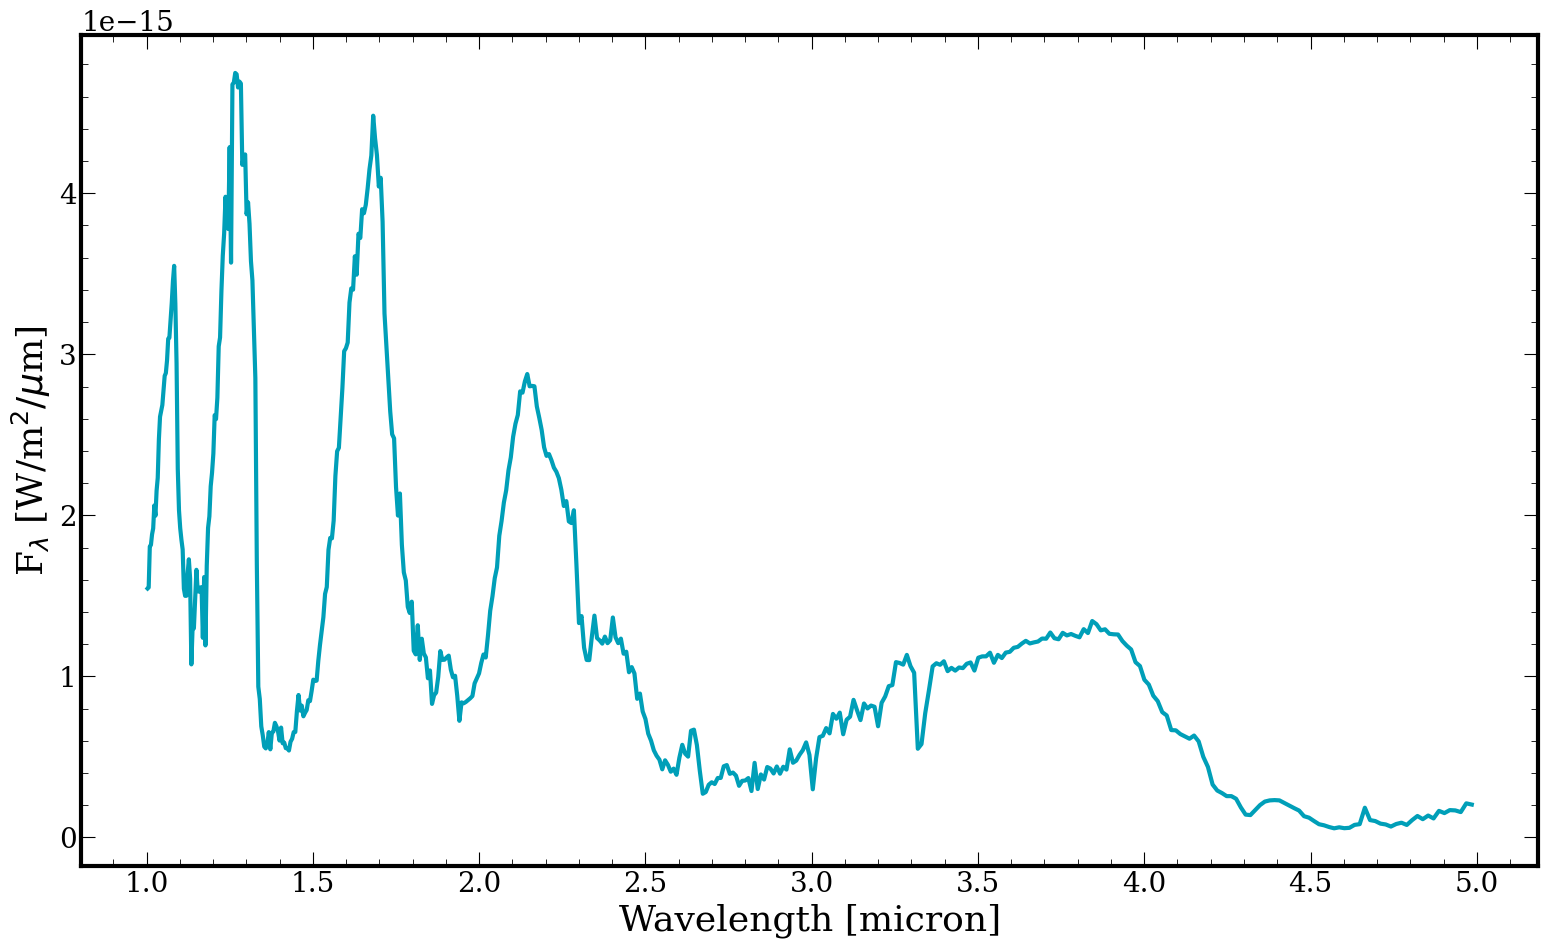

In [6]:
fig, ax = plt.subplots()

ax.plot(wavelength, model, linewidth=3)
ax.set_xlabel("Wavelength [micron]")
ax.set_ylabel(r"F$_{\lambda}$ [W/m$^{2}/\mu$m]")

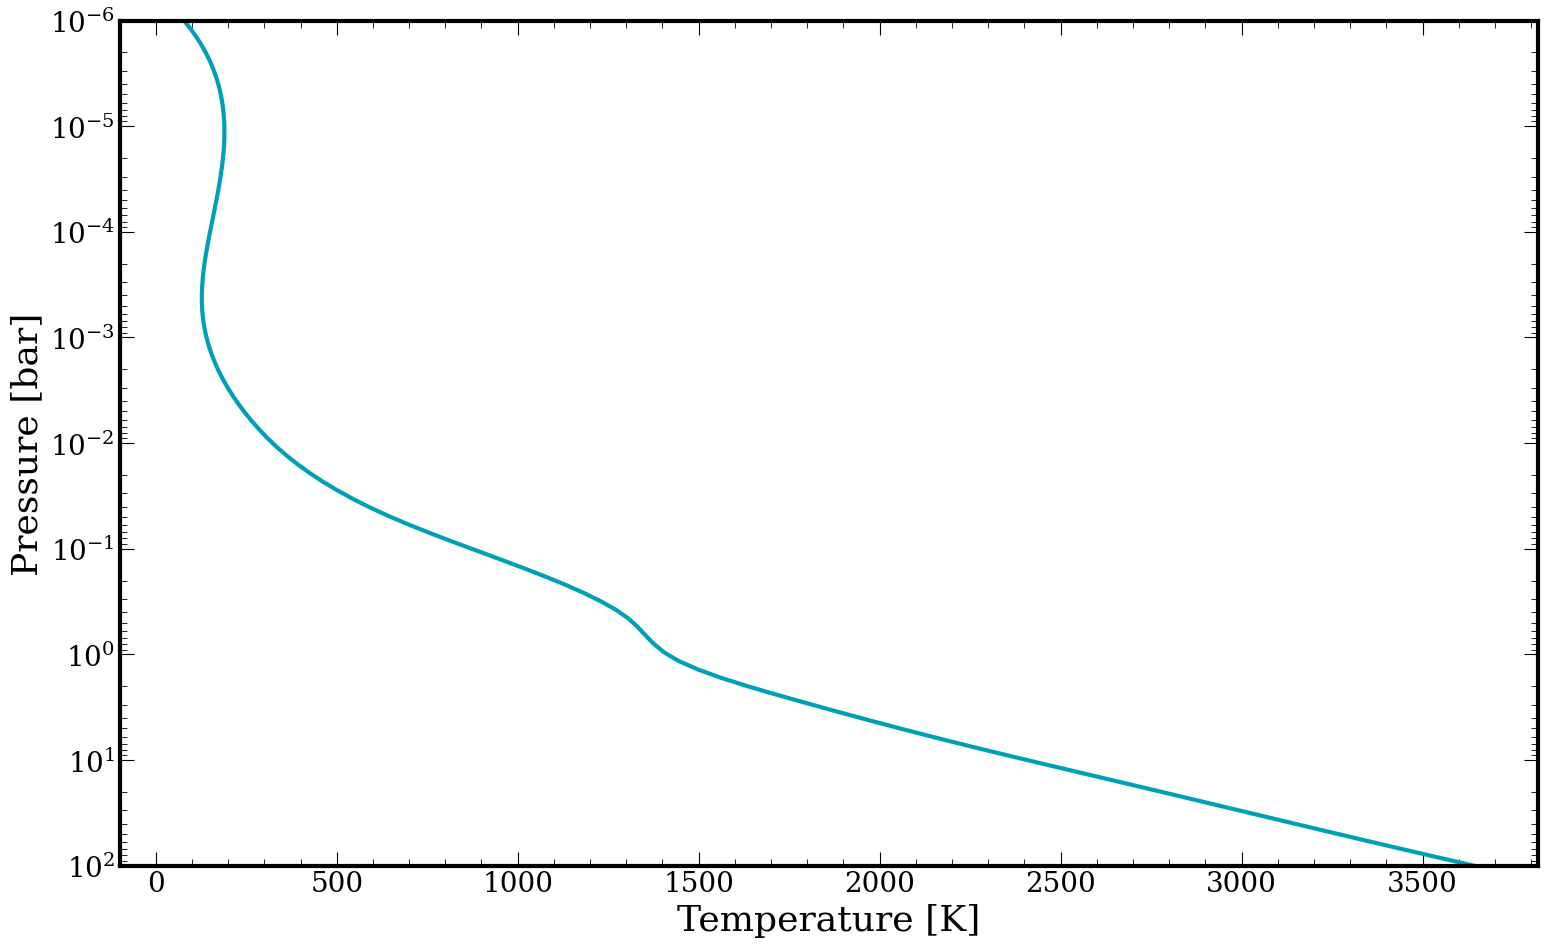

In [7]:
fig, ax = plt.subplots()

ax.plot(temperature, pressure, linewidth=3)
ax.set_xlabel("Temperature [K]")
ax.set_ylabel(r"Pressure [bar]")
ax.set_ylim(1e2,1e-6)
ax.set_yscale('log')

## Transmission spectrum models

We can do the same for the transmission spectrum models:

For every model we need to supply two of the `mass`, `R_pl` or `log_g` in order to compute the surface gravity of the object.
All of the models can combine various cloud implementations, see the [cloud tutorial](./including_clouds.html) for more information.
All of the transmission models can use either (dis)equilibrium or free chemistry, or some combination of the two.
For the specific details of the required parameters, see the [API documentation](../../autoapi/petitRADTRANS/retrieval/models/index.html).

- `isothermal_transmission`: This model assumes a constant temperature throughout the atmosphere. Clouds can be patchy or have complete coverage.
- `guillot_transmission`: This model uses the [Guillot (2010)](https://ui.adsabs.harvard.edu/abs/2010A%26A...520A..27G/abstract) profile,.
- `guillot_patchy_transmission`: Also based on Guillot (2010), this model also allows for the use of patchy clouds.
- `madhu_seager_patchy_transmission`: This model implements the [Madhushudan and Seager (2009)](https://ui.adsabs.harvard.edu/abs/2009ApJ...707...24M/abstract) temperature profile, and also allows for patchy clouds.

In [8]:
from petitRADTRANS.retrieval.models import (
    isothermal_transmission,
    guillot_transmission,
    guillot_patchy_transmission,
    madhu_seager_patchy_transmission
)

For our transmission example, we'll use a WASP-39b-like planet.

*Again, remember that what we do below is different from the retrieval workflow*, where the `Retrieval` object makes the `Radtrans` object; here we just want to calculate a model in isolation.

In [9]:
parameters = {
    # Star parameters
    'stellar_radius': Parameter('stellar_radius', False, value=0.9324 * cst.r_sun),
    # Planet parameters
    'planet_radius': Parameter('planet_radius', False, value=1.3 * cst.r_jup_mean),
    'log_g': Parameter('log_g', False, value=2.75), 
    # Temeprature parameters
    'T_int': Parameter('T_int', False, value=750),
    'T_equ': Parameter('T_equ', False, value=600),
    'log_kappa_IR': Parameter('log_kappa_IR', False, value=-1.0),
    'gamma': Parameter('gamma', False, value=1.0),
    # Cloud parameters
    'haze_factor': Parameter('haze_factor', False, value=0.0),
    'power_law_opacity_350nm': Parameter('power_law_opacity_350nm', False, value=1e-4),
    'power_law_opacity_coefficient': Parameter('power_law_opacity_coefficient', False, value=-1.9),
    'log_Pcloud': Parameter('log_Pcloud', False, value=0),
    # Chemical parameters
    'Fe/H': Parameter('Fe/H', False, value=1.0),
    'C/O': Parameter('C/O', False, value=0.1)
}

In [10]:
line_species = [
    'H2O__POKAZATEL.R300', 
    'CO-NatAbund.R300', 
    'CH4.R300', 
    'CO2.R300', 
    'HCN.R300', 
    'FeH.R300', 
    'H2S.R300', 
    'NH3.R300', 
    'PH3.R300', 
    'Na.R300', 
    'K.R300', 
    'TiO.R300', 
    'VO.R300',
    'SiO.R300'
]

rayleigh_species = ['H2', 'He']
continuum_opacities = ['H2--H2', 'H2--He']
cloud_species = []
pressures = np.logspace(-6,2,100)

atmosphere = prt.radtrans.Radtrans(
    pressures=pressures,
    line_species=line_species,
    rayleigh_species=rayleigh_species,
    gas_continuum_contributors=continuum_opacities,
    cloud_species=cloud_species,
    wavelength_boundaries=[1, 5]
)

Loading Radtrans opacities...
 Done.ng line opacities of species 'H2O__POKAZATEL.R300' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/H2O/1H2-16O/1H2-16O__POKAZATEL.R300_0.3-50mu.ktable.petitRADTRANS.h5'...
 Done.ng line opacities of species 'CO-NatAbund.R300' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/CO/C-O-NatAbund/C-O-NatAbund__HITEMP.R300_0.1-250mu.ktable.petitRADTRANS.h5'...
 Done.ng line opacities of species 'CH4.R300' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/CH4/12C-1H4/12C-1H4__YT34to10.R300_0.3-50mu.ktable.petitRADTRANS.h5'...
 Done.ng line opacities of species 'CO2.R300' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/CO2/12C-16O2/12C-16O2__UCL-4000.R300_0.3-50mu.ktable.petitRADTRANS.h5'...
 Done.ng line opacities of species 'HCN.R300' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/HCN/1H-12C-14N/1H-12C-14N__Harri

In [11]:
wavelength, model = guillot_transmission(atmosphere, parameters, amr = False, pt_plot_mode = False)
pressure,temperature = guillot_transmission(atmosphere, parameters, amr = False, pt_plot_mode = True)

Text(0, 0.5, 'F$_{p}$/F$_{\\rm star}$ [ppm]')

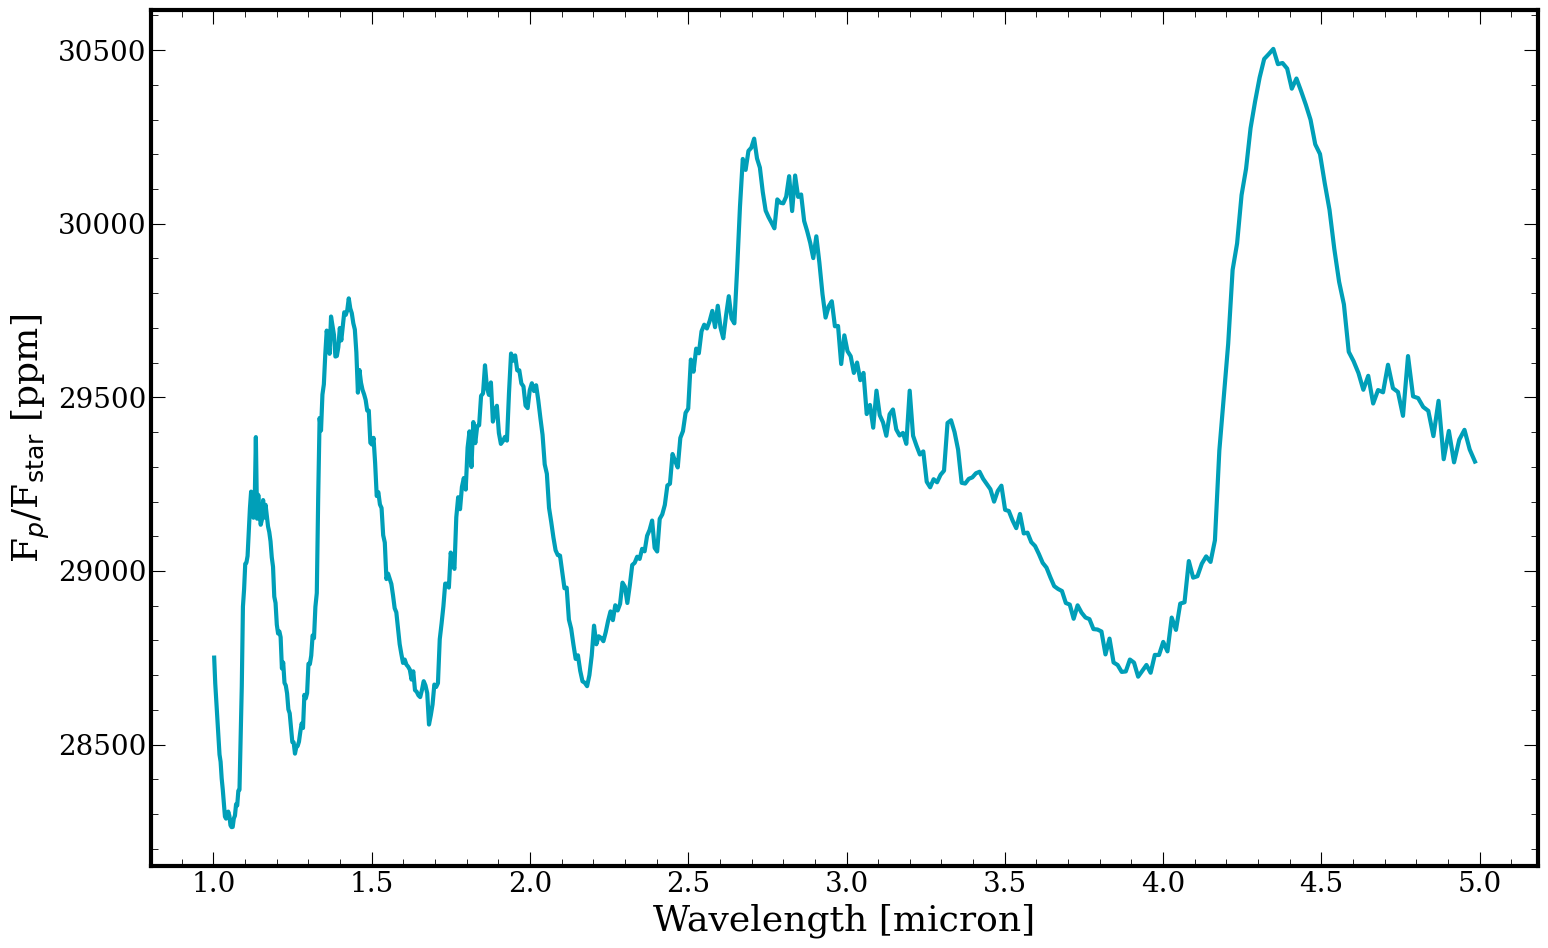

In [12]:
fig, ax = plt.subplots()
ax.plot(wavelength, model*1e6, linewidth = 3)
ax.set_xlabel("Wavelength [micron]")
ax.set_ylabel(r"F$_{p}$/F$_{\rm star}$ [ppm]")

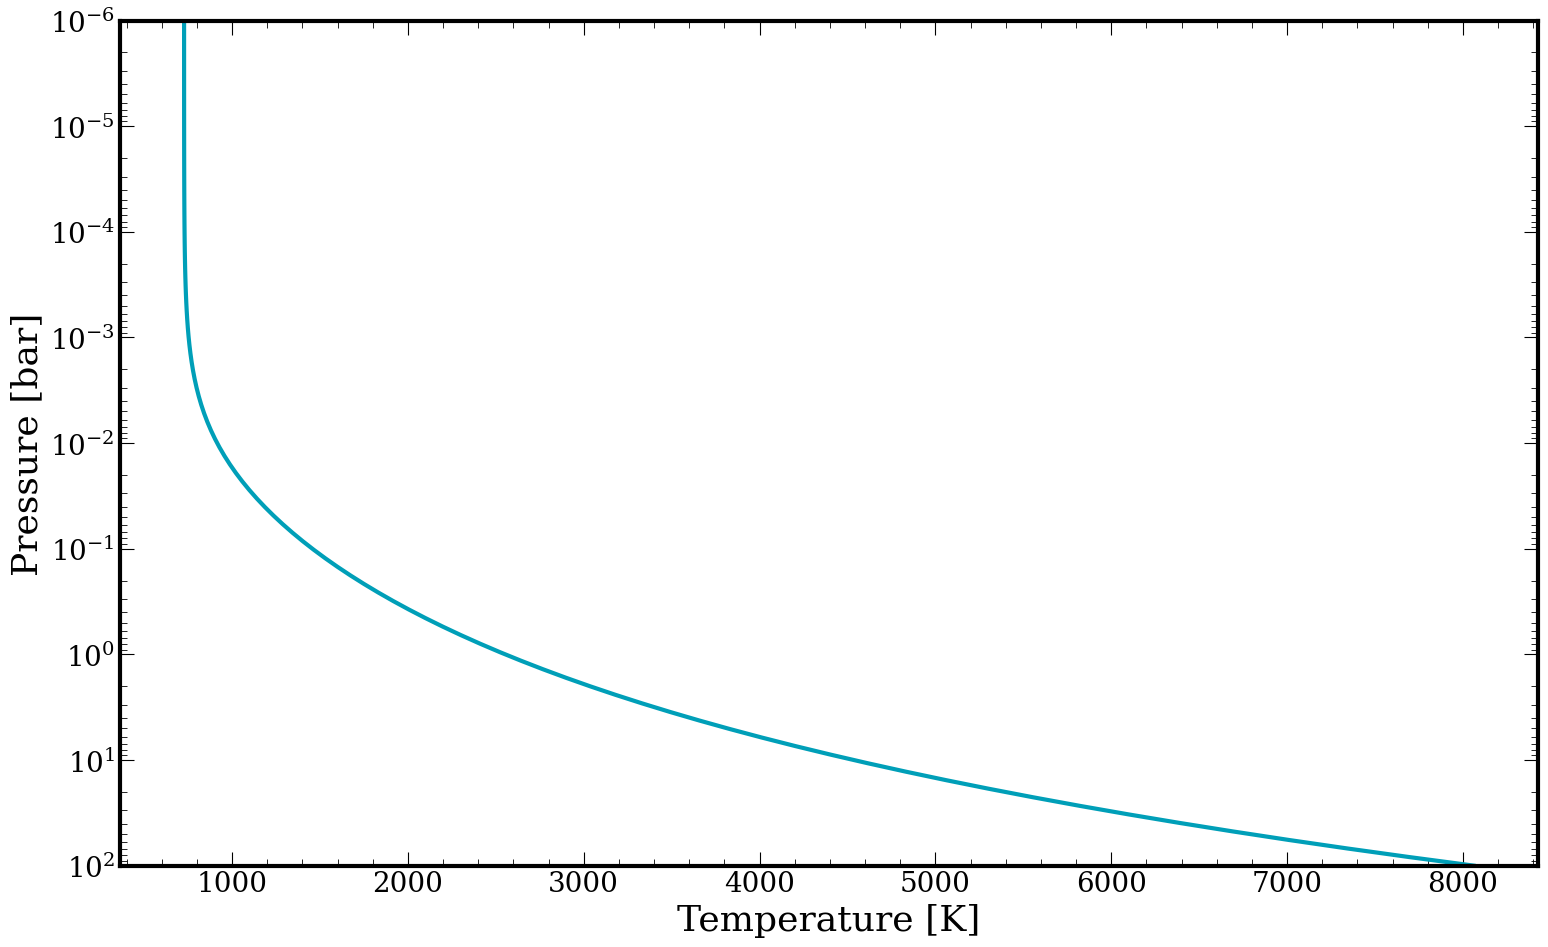

In [13]:
fig, ax = plt.subplots()
ax.plot(temperature, pressure, linewidth = 3)
ax.set_xlabel("Temperature [K]")
ax.set_ylabel(r"Pressure [bar]")
ax.set_ylim(1e2,1e-6)
ax.set_yscale('log')